Now, we come to the real thing. Who are the most important Pythonistas in Nashville?

We will follow a similar setup to last time, but with a few minor twists. We will have to translate our (person, event) edges to (person, person) edges using a *bipartite* "projection". We also need to spend a little more time thinking through what implications this has for our measures.

Our plan is to:

1. Load in and subset the MeetUp RSVP data.
2. Create a *member-to-member* graph from the *member-to-event* data.
3. Use "degree" and "betweenness centrality" to determine member importance.

### 1. Load in and subset the MeetUp RSVP data.

First, we load our packages and full datasets.

In [1]:
import pandas as pd
import numpy as np

# Read in metadata
members = pd.read_csv('data/members.csv', index_col='member_id')
groups = pd.read_csv('data/groups.csv', index_col='group_id')
events = pd.read_csv('data/events.csv', index_col='event_id')

# Read in edge data
rsvps = pd.read_csv('data/rsvps.csv')

The group_id for PyNash is **11625832**, so we can limit our analysis to only those events in that list. 

In [2]:
# Get PyNash events
pynash_id = 11625832
pynash_event_ids = events.loc[events.group_urlname == 'PyNash'].index.tolist()

# Get list of unique member_ids attending a PyNash event
pynash_rsvps = rsvps.loc[rsvps.event_id.isin(pynash_event_ids)]
pynash_member_ids = pynash_rsvps['member_id'].unique().tolist()

print('There are {} PyNash events.'.format(len(pynash_event_ids)))
print('There are {} PyNash attendees.'.format(len(pynash_member_ids)))

There are 46 PyNash events.
There are 526 PyNash attendees.


##### Build the graph with NetworkX

In [3]:
import networkx as nx

g = nx.from_pandas_dataframe(pynash_rsvps, 
                             source='member_id', 
                             target='event_id')

# Add "Node Type" attribute 
node_type_dict = {n: ('member' if n in pynash_member_ids else 'event') 
                        for n in g.nodes}
nx.set_node_attributes(g, node_type_dict, 'node_type')

##### Plot the PyNash graph

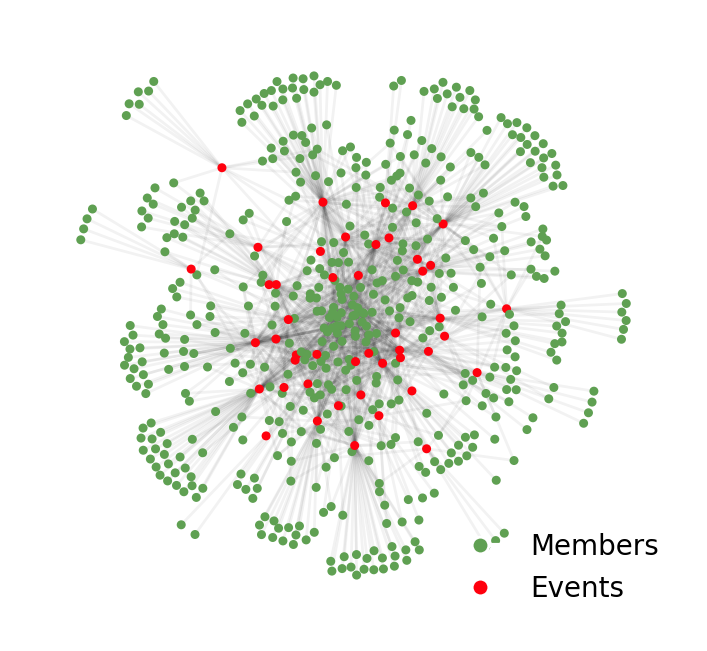

In [4]:
import matplotlib.pyplot as plt
from utils import setup_graph_plot

fig, ax = setup_graph_plot(dpi=200)

pos = nx.spring_layout(g)
colors = ['xkcd:muted green' if g.nodes[n]['node_type'] == 'member'
              else 'xkcd:bright red' for n in g.nodes]
nx.draw_networkx_nodes(g, pos, node_color=colors, node_size=5,
                       with_labels=False)
nx.draw_networkx_edges(g, pos, alpha=0.05)

# Draw a legend
handles = [plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="xkcd:muted green"), 
           plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="xkcd:bright red")]
plt.legend(handles, ['Members', 'Events'], frameon=False)

plt.show()

### 2. Create a *member-to-member* graph from the *member-to-event* data.

We have all the data we need - we simply need to project it into the correct format. There are a few functions in `nx.bipartite` that can help us do this. 

But let's recall what is special about a bipartite graph:

1. There are two distinct sets of nodes. 
    - There are connections *between* sets.
    - Therea are no connections *within* sets. 
2. This data is common when you have "affiliation" data where you have one type of data that is a person and another type that is a thing.

We can test for bipartite-ness in NetworkX. We can also pull out the sets automatically.

In [5]:
nx.is_bipartite(g)

True

In [6]:
member_nodes, event_nodes = nx.bipartite.sets(g)
print('There are {} members and {} events.'.format(len(member_nodes), len(event_nodes)))

There are 526 members and 46 events.


To get the projected graphs, we use the `weight_projected_graph` function. This will create a member graph with the following properties:

- Nodes are member_ids.
- Edges are the number of shared events between two members.

In [7]:
gm = nx.bipartite.weighted_projected_graph(B=g, nodes=member_nodes, ratio=False)

# You can do the same for events
ge = nx.bipartite.weighted_projected_graph(g, event_nodes, False)

### Use "degree" and "betweenness centrality" to determine importance.

Finally, we are going to measure different aspects of our graph. Most

In [8]:
# Initialize df
df_members = pd.DataFrame(index=gm.nodes)

# Add graph measures
df_members['num_events'] = pd.Series(dict(g.degree)) #"DegreeView" must be converted to dict
df_members['degree'] = pd.Series(dict(gm.degree))
df_members['centrality'] = pd.Series(nx.betweenness_centrality(gm))

# Sample output
df_members.head()

,num_events,degree,centrality
58462212,1,75,0.000000
214085642,1,70,0.000000
197928971,2,82,0.000169
66609162,1,65,0.000000
2069,4,52,0.001035


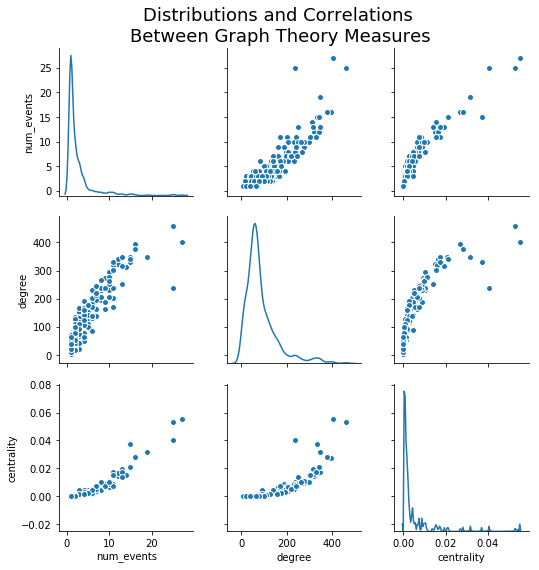

In [9]:
import seaborn as sns

sns.pairplot(data=df_members, diag_kind='kde')
plt.suptitle('Distributions and Correlations \nBetween Graph Theory Measures', 
             y=1.05, fontsize=18)

plt.show()

A few things become apparent within the PyNash graph:

1. Degree is strongly correlated with number of events attended.
2. Centrality increases exponentially relative to degree.
3. Centrality is more skewed than the other metrics -- there are only a few highly central people.

But who is are they???

In [10]:
top_ten = df_members.sort_values(by='centrality', ascending=False).head(10).join(members)
top_ten[['name', 'city', 'num_events', 'degree', 'centrality']]

,name,city,num_events,degree,centrality
121334792,Greg Back,Hendersonville,27,403,0.055124
57907252,Chad Upjohn,Nashville,25,459,0.053080
30123762,Jason Myers,Nashville,25,237,0.040602
2896514,Trey Brooks,Nashville,15,331,0.037175
184547023,Chris Jarvis,Nashville,19,347,0.031768
12140530,Bill Israel,Nashville,16,378,0.028138
202882025,Michael mead,Nashville,16,396,0.027081
13606604,Alex Simonian,Nashville,15,343,0.021315
126309962,Aliya Gifford,Nashville,15,348,0.020821
4393825,Chris Fonnesbeck,Nashville,13,316,0.019495


One revealing thing comes out: Jason Myers has a degree that is almost 100 less than everyone else in the top ten. Yet he is number 3 on the list! How can this be?

The answer lies in PyNash's event offerings, which break into two categories: 

- PyNash Lunch - attended by a small number of regulars 
- PyNash Talks - attended by a large number of regulars and newbies

Let's take a look at the attendance records for Jason Myers and Chad Upjohn:

In [11]:
print('**PyNash Attendance for Jason Myers**')
print(pynash_rsvps.loc[pynash_rsvps.member_id==30123762]
     .set_index('event_id')
     .join(events).name
     .value_counts() )

print('\n')
print('**PyNash Attendance for Chad Upjohn**')
print(pynash_rsvps.loc[pynash_rsvps.member_id==57907252]
     .set_index('event_id')
     .join(events).name
     .value_counts() )

**PyNash Attendance for Jason Myers**
PyNash Lunch!                                                                    23
PyNash: Virtualenv/Virtualenvwrapper(Bill Israel), Code Analysis(Jason Myers)     1
You and I and the PyNash API                                                      1
Name: name, dtype: int64


**PyNash Attendance for Chad Upjohn**
PyNash Lunch!                                                                    5
Logging beyond /dev/null -- ELK Stack for Log Visualization and Analysis         1
A Beginners Guide to Supervised Machine Learning with scikit-learn               1
A Brief Introduction to Concurrency and Coroutines in Python 3.5                 1
Intro to Profiling in Python                                                     1
An October Two-fer: Refactoring, Extra Code Included / PDFs Against Humanity     1
Interactive Python Environments: IPython, Jupyter, and Beaker, Oh My!            1
A Gentle, Pythonic Introduction to Operating Systems            

The reason for Jason's uncharacteristically high centrality is that he has RSVPed to nearly all the lunches, while others have gone to higher "degree-granting" events. Consequently, Jason is deeply embedded within the social fabric of the graph (many links to the most important people), despite not having as broad of a reach himself.

##### Draw Member Graph

To conclude, let's take a quick look at the member graph to drive home the fact that PyNash is held together by a small group of highly connected individuals. First, we take a look at the graph representation.

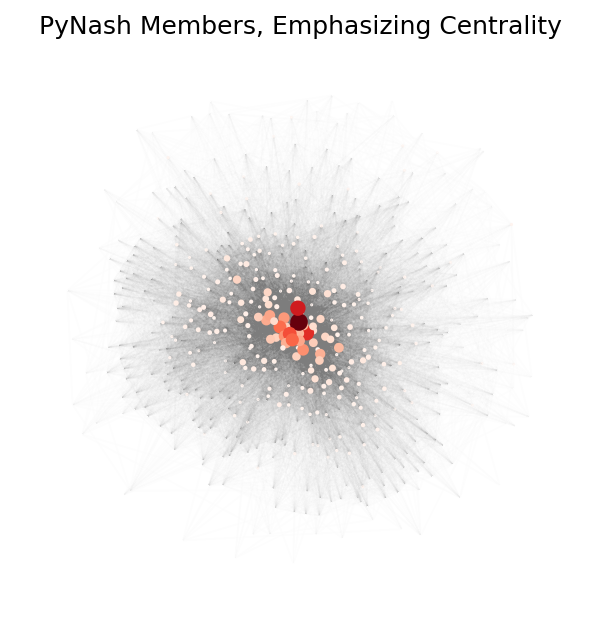

In [12]:
import matplotlib as mpl
from utils import setup_graph_plot

fig, ax = setup_graph_plot(figsize=(5,5), dpi=150)

member_pos = nx.spring_layout(gm, k=1)

# Create a centrality-weighted colormap for the nodes
from matplotlib import colors
norm = colors.Normalize(vmin=-0.2, vmax=df_members.centrality.max())

nx.draw_networkx_nodes(gm, member_pos, alpha=1, 
                       node_size=[1000*x for x in df_members.centrality],
                       node_color=[norm(x) for x in df_members.centrality], 
                       cmap=plt.cm.Reds)
nx.draw_networkx_edges(gm, member_pos, alpha=0.008)

plt.title('PyNash Members, Emphasizing Centrality')

plt.show()

Next, let's check out the adjacency matrix, which can sometimes make edge patterns clearer. Let's sort by centrality to see what sorts of patterns we can make out in the edge relationships.

As you go further down and right, individuals have a much higher number of edges. In fact, the last ten or fifteen rows/columns are connected to almost every other member in the graph -- these are our top Pythonistas. 

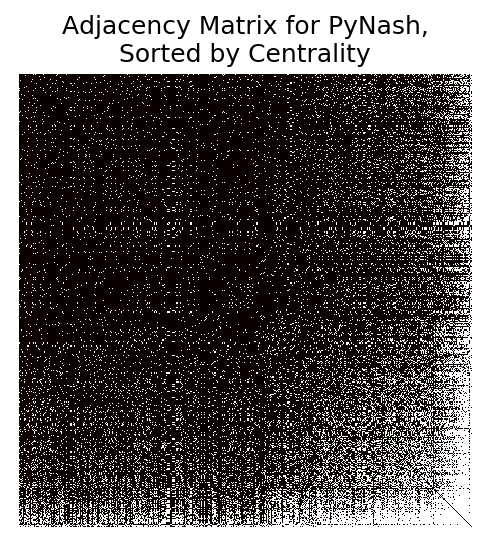

In [15]:
fig, ax = setup_graph_plot(dpi=150)

node_order = df_members.sort_values(by='centrality').index
adjmat_weighted = nx.to_numpy_array(gm, nodelist=node_order)
adjmat_binary = adjmat_weighted > 0

ax.imshow(adjmat_binary, cmap='hot')

plt.title('Adjacency Matrix for PyNash,\nSorted by Centrality')
plt.show()